In [2]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using LaTeXStrings
LaTeXStrings

LaTeXStrings

In [3]:
include("../../julia-r3bp/R3BP/src/R3BP.jl")
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16

┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


16

In [4]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end

plot_circle (generic function with 2 methods)

In [5]:
# moon     = plot_circle(1-param3b.mu2, param3b.as , 0.0)
# earth    = plot_circle(param3b.mu2, param3b.as, 0.0)
# earth_ub = plot_circle(param3b.mu2+6375/param3b.lstar, param3b.as, 0.0)
# earth_lb = plot_circle(param3b.mu2-6375/param3b.lstar, param3b.as, 0.0)
# moon_soi_outer = plot_circle(1-param3b.mu2+66000/param3b.lstar, param3b.as, 0.0);

# in km 
moon     = plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [15]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename = "../run/data/grid_search_Tsit5_0522_EMrotThrust.csv"
# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_EMrotdir_sb1frame 

# 3body parameter
param3b = SailorMoon.dynamics_parameters()

n_arc = 5
##################################################

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = DataFrame(CSV.File(filename))

# maybe want to use "for row in eachrow(df)" to automate the process...? 
row = df[19,:]

sv_mid_cart = [row.x_ra, row.y_ra, row.z_ra, row.xdot_ra, row.ydot_ra, row.zdot_ra]
# change the coordinates into cylindrical (only position)
svm_mid_cyl = vcat(SailorMoon.cart2cylind_only_pos(sv_mid_cart), row.m_ra)

tof_leo2mid = row.dt2
tof_mid2lpo = row.dt1
tof = row.tof
rp = row.rp_kep
ra = row.ra_kep
α = row.alpha
m_rp = row.m_rp

θsf = row.thetasf
ϕ0  = row.phi0

x_lpo  = row.x_lpo
y_lpo  = row.y_lpo
z_lpo  = row.z_lpo
vx_lpo = row.xdot_lpo
vy_lpo = row.ydot_lpo
vz_lpo = row.zdot_lpo



-1.42e-21

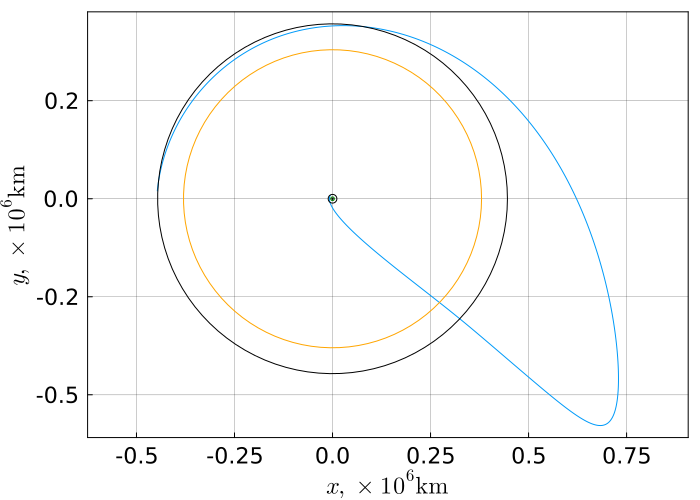

In [16]:
svf = [x_lpo, y_lpo, z_lpo, vx_lpo, vy_lpo, vz_lpo, 1.0]
tspan = [0, -tof]
params = [
    param3b.mu2, param3b.mus, param3b.as, pi - θsf, param3b.oml, param3b.omb, 
    1.0, 0.0, 0.0, 
    paramMulti.mdot, paramMulti.tmax, dir_func, param3b.tstar
]
prob = ODEProblem(SailorMoon.rhs_bcr4bp_sb1frame2_thrust_bal!, svf, tspan, params)
sol = solve(prob, Tsit5(); reltol=1e-12, abstol=1e-12)


pcart_ = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", 
#     ylabel = "test",
    ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

plot!(pcart_, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar)

plot!(pcart_, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart_, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart_, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6; digits=1))),
)

# savefig("ini_guess.png")

In [ ]:
ig_x, lx, ux = SailorMoon.make_ig_bounds2(row, τ_ig, paramMulti.n_arc);
res, sol_param_list, sols_ballistic, _ = SailorMoon.multishoot_trajectory2(ig_x, dir_func, paramMulti, true, true);
println(res)
norm(res)

In [ ]:
pcart = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

arcs_color = Dict(
    "xlr_bck_arc" => :navy, 
    "xlr_fwd_arc" => :pink,
    "mid_bck_arc" => :red1, 
    "mid_fwd_arc" => :darkorange, 
    "lpo_arc" => :green
)



# plot!(hcat(sol_.u...)[1,:], hcat(sol_.u...)[2,:], color=:black, label="backward(from LLO):0.001", set_aspect=:equal, size=(700,700))


# ballistic legs
for sol_ballistic in sols_ballistic
    plot!(pcart, (hcat(sol_ballistic.u...)[1,:].-param3b.as).*param3b.lstar, hcat(sol_ballistic.u...)[2,:].*param3b.lstar, c=:dodgerblue, label=false)
end

# trajectory
# for i = 1:length(sol_param_list)
#     sol, _, name = sol_param_list[i]
#     #if name == "mid_bck_arc" || name == "mid_fwd_arc" || name == "lpo_arc"
#     plot!(pcart, sol[1,:], sol[2,:], 
#         linewidth=1.5, label="$name", c=arcs_color[name])
#     #end
# end

# trajectory
# starting from 2, excluding the first LEO arc now...
for i = 1:length(sol_param_list)
    sol, _, name = sol_param_list[i]
    plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, label="$name", c=arcs_color[name])
    scatter!(pcart, 
        [(sol[1,1]-param3b.as)*param3b.lstar, (sol[1,end] - param3b.as)*param3b.lstar], 
        [sol[2,1]*param3b.lstar, sol[2,end]*param3b.lstar], label=false, c=arcs_color[name], marker=:circle)
end

# control node
# scatter!(pcart, [x_mid[1]], [x_mid[2]], marker=:circle, color=:black, label="MP")
# scatter!(pcart, [param3b.as], [0.0], marker=:circle, color=:black)

# plot the earth when the initial guess is terminated 
# θm0 = π - (θsf - param3b.oms * tof)
# e0x = param3b.as - param3b.mu2*cos(θm0)
# e0y = - param3b.mu2 * sin(θm0)
# earth0 = plot_circle(6375/param3b.lstar, e0x, e0y)

# plot!(pcart, earth0[1,:], earth0[2,:], c=:red, lw=1.0, label="earth")
# scatter!(pcart, [e0x], [e0y], color=:red, markersize=2.5)


plot!(pcart, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")

plot!(pcart, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6; digits=1))),
)
savefig("multi_shooting.png")


You should be able to get necessary plots until here...

In [ ]:
# converged solution (03/23, wrong!!!)
xopt2 = [387.8361917242459, -0.3853476760186616, -0.04247313041034335, -0.9323199473757933, -0.4330087021017924, -0.03246075114595058, 1.0074803628470648, 0.6208073838508084, 3.624171797062712, 0.505666575900808, 0.026244288314327468, 0.0005489785148977199, 0.5037377780138078, 0.018839912759376232, 0.0004837026973513516, 0.5017378554937434, 0.012413994633042585, 0.0003652633319893791, 0.4997183841937381, 0.006764295811492612, 0.00021503385619908998, 0.49818057582675834, 0.002209518257796944, 0.00019915043559496268, 0.7213579294499163, 0.18696527439755153, -0.011478536870172099, 0.9022781401589027, 0.2024486332934889, -0.02650777872915466, 0.9470201428586926, 0.19370405655792194, -0.031034299472032435, 0.9613467304011643, 0.18436494397567382, -0.031004090068095232, 0.9680800935604605, 0.18059223799578025, -0.02917096363825062, 386.7179789619507, -0.001911212825674917, -0.10611725410211326, -0.24904357645705139, -0.1663860481066939, 0.03778647354623657, 1.001325235082276, 14.668779881743394, 4.913400857534562, 0.42924264571930676, -1.9042652466463357, -1.304001523556738, 0.43089641310137883, -1.947572867423033, -1.2770895393048303, 0.4349563275960081, -1.9878366288500038, -1.2528496029711456, 0.4415870204833449, -2.0254685430089077, -1.230845461160481, 0.4501340592031054, -2.060492342619702, -1.210765944999106, 0.9779254808724199, -0.49204994677131564, -1.8225144993349944, 0.9712167730497783, -0.6622791631515925, -2.2646211613594915, 0.9803100959702216, -0.7286560074316265, -2.060239572997394, 0.9782407691308137, -0.5647768545998232, -1.5479850242257065, 0.9793643596642534, -1.2650738316028962, -2.688034638868756, 1.9384056484221754, 1.4207874944484553, 0.9777823758947515, 7.226584511880099, 0.9667106142377015, -1.0347206794531993, 0.05194317681147863, 0.9697708190238273, -0.3055054325629812, 0.06564884539836179, 0.9763657712922017, -0.12158282927199301, -0.05321147127190784, 0.9796339189305757, 0.01615092440024013, -0.098462320532415, 0.9815885413776649, 0.051565939292446274, -0.09950068249486148]
res2, sol_param_list2, sols_ballistic2, _ = SailorMoon.multishoot_trajectory2(xopt2, dir_func, paramMulti, true, true);
res2

In [ ]:
arcs_color = Dict(
    "xlr_bck_arc" => :navy, 
    "xlr_fwd_arc" => :pink,
    "mid_bck_arc" => :red1, 
    "mid_fwd_arc" => :darkorange, 
    "lpo_arc" => :green
)

pcart = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false
)
plot!(pcart, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")

plot!(pcart, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer")

# plot!(hcat(sol_.u...)[1,:], hcat(sol_.u...)[2,:], color=:black, label="backward(from LLO):0.001", set_aspect=:equal, size=(700,700))


# ballistic legs
for sol_ballistic in sols_ballistic2
    plot!(pcart, hcat(sol_ballistic.u...)[1,:], hcat(sol_ballistic.u...)[2,:], c=:dodgerblue, label=false)
end

# trajectory
# for i = 1:length(sol_param_list)
#     sol, _, name = sol_param_list[i]
#     #if name == "mid_bck_arc" || name == "mid_fwd_arc" || name == "lpo_arc"
#     plot!(pcart, sol[1,:], sol[2,:], 
#         linewidth=1.5, label="$name", c=arcs_color[name])
#     #end
# end

# trajectory
# starting from 2, excluding the first LEO arc now...
for i = 1:length(sol_param_list2)
    sol, _, name = sol_param_list2[i]
    plot!(pcart, sol[1,:], sol[2,:], label="$name", c=arcs_color[name])
    scatter!(pcart, [sol[1,1],sol[1,end]], [sol[2,1],sol[2,end]], label=false, c=arcs_color[name], marker=:circle)
end

# control node
# scatter!(pcart, [x_mid[1]], [x_mid[2]], marker=:circle, color=:black, label="MP")
scatter!(pcart, [param3b.as], [0.0], marker=:circle, color=:black)

# plot the earth when the initial guess is terminated 
θm0 = π - (θsf - param3b.oms * tof)
e0x = param3b.as - param3b.mu2*cos(θm0)
e0y = - param3b.mu2 * sin(θm0)
earth0 = plot_circle(6375/param3b.lstar, e0x, e0y)

plot!(pcart, earth0[1,:], earth0[2,:], c=:red, lw=1.0, label="earth")
scatter!(pcart, [e0x], [e0y], color=:red, markersize=2.5)


pcart

In [ ]:
pcart2 = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false
);

sol1, _, _ = sol_param_list2[1]
sol2, _, _ = sol_param_list2[2]
sol3, _, _ = sol_param_list2[3]
sol4, _, _ = sol_param_list2[4]
sol5, _, _ = sol_param_list2[5]

plot!(pcart2, sol1.t, hcat(sol1.u...)[5,:])
plot!(pcart2, sol2.t, hcat(sol2.u...)[5,:])
plot!(pcart2, sol3.t, hcat(sol3.u...)[5,:])
plot!(pcart2, sol4.t, hcat(sol4.u...)[5,:])
plot!(pcart2, sol5.t, hcat(sol5.u...)[5,:])